In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
# We use Python's `functools.partial` to create a new function based on `FastSystem` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff


# Define the ODE systems
def fast_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Create a new function, "fast_subsystem" with eps=0 based on fast_system
fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  # Small perturbation
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
equilibrium_points = [np.zeros(len(fast_system([0, 0, 0], 0, 0)))] # [np.zeros(len(y))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def slow_subsystem(y, tau):
    x, y, z = y
    dxdtau = 0
    dydtau = 0
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]



eps = 0.01
# Initial points x, y, z:
x_init, y_init, z_init = 1.0 + 0 * eps, 0.0 - 0 * eps, 0.0 + 0 * eps
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}, z_init = {z_init}")

t_end = 100
t  =  np.linspace(0, t_end, 200)
t2  =  np.linspace(0, -t_end, 200)

T_slow_end = 1
tau = np.linspace(0, T_slow_end, 200)


x_end, y_end, z_end = 0.0 - 0 * eps, 1.0 + 0 * eps, 1.0 + 0 * eps
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}, z_end = {z_end}")

# Define the exact solution
def fast_solution(t, eps, x0, y0, z0):
    lambda1, lambda2, lambda3 = eigenvalues
    x_real_fast = x0 * np.exp(lambda1 * t)
    y_real_fast = y0 * np.exp(lambda2 * t)
    z_real_fast = np.full_like(t, z0)
    return x_real_fast, y_real_fast, z_real_fast

def slow_solution(tau, eps, x0, y0, z0):
    lambda_slow = eigenvalues[0]
    x_real_slow = np.full_like(tau, 0)
    y_real_slow = np.full_like(tau, 0)
    z_real_slow = z0 + tau
    return x_real_slow, y_real_slow, z_real_slow



# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = fast_solution(t, eps, x_init, y_init, z_init)
xf_end, yf_end, zf_end = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]
x_exact_slow, y_exact_slow, z_exact_slow = slow_solution(tau, eps, xf_end, yf_end, zf_end)
x_exact_fast2, y_exact_fast2, z_exact_fast2 = fast_solution(t2, eps, x_end, y_end, z_end)



# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64)
x_real_fast_tensor = torch.tensor(x_exact_fast.reshape(-1, 1), dtype=torch.float64)
y_real_fast_tensor = torch.tensor(y_exact_fast.reshape(-1, 1), dtype=torch.float64)
z_real_fast_tensor = torch.tensor(z_exact_fast.reshape(-1, 1), dtype=torch.float64)

tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
x_real_slow_tensor = torch.tensor(x_exact_slow.reshape(-1, 1), dtype=torch.float64)
y_real_slow_tensor = torch.tensor(y_exact_slow.reshape(-1, 1), dtype=torch.float64)
z_real_slow_tensor = torch.tensor(z_exact_slow.reshape(-1, 1), dtype=torch.float64)

t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)
x_real_fast2_tensor = torch.tensor(x_exact_fast2.reshape(-1, 1), dtype=torch.float64)
y_real_fast2_tensor = torch.tensor(y_exact_fast2.reshape(-1, 1), dtype=torch.float64)
z_real_fast2_tensor = torch.tensor(z_exact_fast2.reshape(-1, 1), dtype=torch.float64)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 5

def loss_func_fast(model, t_tensor, x_init, y_init, z_init,\
                                   x_f_end, y_f_end, z_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1),\
                                            pred_fast[:, 1].unsqueeze(1),\
                                            pred_fast[:, 2].unsqueeze(1)

           
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast
    residual3_fast = dz_dt
    #for the main fast system
    residual4_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual5_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) +\
                     torch.square(z_pred_fast[0] - z_init)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2)

    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) +\
                         torch.square(z_pred_fast[-1] - z_f_end)
    
    
    total_loss_fast = phys_weight * physics_loss_fast + init_loss_fast + boundary_loss_fast

    return total_loss_fast

def loss_func_fast2(model, t2_tensor, x_end, y_end, z_end,\
                                    x_f2_end, y_f2_end, z_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1),\
                                               pred_fast2[:, 1].unsqueeze(1),\
                                               pred_fast2[:, 2].unsqueeze(1)
    
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast2 = dx_dt2 + x_pred_fast2
    residual2_fast2 = dy_dt2 - 2 * y_pred_fast2
    residual3_fast2 = dz_dt2
    # Compute residuals for fast_subsystem
    residual4_fast2 = dy_dt2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual5_fast2 = dz_dt2 - eps * (x_pred_fast2**2 + 1)
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) +\
                      torch.square(z_pred_fast2[0] - z_end)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2 + residual4_fast2**2 +\
                                    residual5_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) +\
                          torch.square(z_pred_fast2[-1] - z_f2_end)
    total_loss_fast2 = phys_weight * physics_loss_fast2 + init_loss_fast2 + boundary_loss_fast2

    return total_loss_fast2

def loss_func_slow(model, tau_tensor, x_1, y_1, z_1, x_2, y_2, z_2, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)   
    
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    residual1_slow = eps * dx_dtau + x_pred_slow  # dx_dtau + x_pred_slow / eps
    residual2_slow = eps * dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) # dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) / eps
    residual3_slow = dz_dtau - x_pred_slow**2 - 1

    residual4_slow = x_pred_slow
    residual5_slow = y_pred_slow
    
    init_loss_slow = torch.square(x_pred_slow[0] - x_1) +\
                     torch.square(y_pred_slow[0] - y_1) +\
                     torch.square(z_pred_slow[0] - z_1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2 + residual4_slow**2 + residual5_slow**2)
    
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_2) +\
                         torch.square(y_pred_slow[-1] - y_2) +\
                         torch.square(z_pred_slow[-1] - z_2)
    total_loss_slow = phys_weight * physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow


def total_loss_func(model_fast, model_slow, model_fast2,\
                    t_tensor, tau_tensor, t2_tensor,\
                    x_init, y_init, z_init, x_f_end, y_f_end, z_f_end,\
                    x_1, y_1, z_1, x_2, y_2, z_2,\
                    x_end, y_end, z_end, x_f2_end, y_f2_end, z_f2_end, eps,\
                    weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init, z_init,\
                                                   x_f_end, y_f_end, z_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end, z_end,\
                                                   x_f2_end, y_f2_end, z_f2_end, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor,\
                               x_1, y_1, z_1, x_2, y_2, z_2, eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss





class VanillaPINN(nn.Module):
    def __init__(self):
        super(VanillaPINN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, t):
        x = torch.tanh(self.fc1(t))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def loss_func_vanilla(model, t_tensor, x_exact, y_exact, z_exact, x0, y0, z0, xT, yT, zT, eps):
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    x_pred, y_pred, z_pred = pred[:, 0].unsqueeze(1), pred[:, 1].unsqueeze(1), pred[:, 2].unsqueeze(1)
    
    ones = torch.ones_like(x_pred, requires_grad=True)
    dx_dt = torch.autograd.grad(x_pred, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    
    residual1 = dx_dt + x_pred
    residual2 = dy_dt - (2 * y_pred + eps * x_pred)
    residual3 = dz_dt - eps * (x_pred**2 + 1)

    
    physics_loss = torch.mean(residual1**2 + residual2**2 + residual3**2)
    
    init_loss = (x_pred[0] - x0)**2 + (y_pred[0] - y0)**2 + (z_pred[0] - z0)**2
    boundary_loss = (x_pred[-1] - xT)**2 + (y_pred[-1] - yT)**2 + (z_pred[-1] - zT)**2
    
    total_loss = physics_loss + init_loss + boundary_loss
    return total_loss
  



Jacobian Matrix:
[[-1.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
Eigenvalues:
[-1.  2.  0.]
Eigenvectors:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.0, y_init = 0.0, z_init = 0.0
The ending points of the BVP: x_end = 0.0, y_end = 1.0, z_end = 1.0


In [6]:
device = torch.device('cpu')  # Ensures everything runs on the CPU

if __name__ == '__main__':

    torch.manual_seed(42)
    np.random.seed(42)
    mse_history_multiscale = {
        'total': []     
    }
    mse_history_vanilla = {
        'total': []     #MSE
    }
    print("\nTraining GSPINN...")
    start_time_multiscale = time.time()
    
    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values_multiscale = []
    epoch_num = 10000

    xf_end, yf_end, zf_end = np.random.random(), np.random.random(), np.random.random()    
    xf2_end, yf2_end, zf2_end = np.random.random(), np.random.random(), np.random.random()

    xs_init, ys_init, zs_init = np.random.random(), np.random.random(), np.random.random()
    xs_end, ys_end, zs_end = np.random.random(), np.random.random(), np.random.random()


    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, z_init, xf_end, yf_end, zf_end,\
                                     xs_init, ys_init, zs_init,\
                                     xs_end, ys_end, zs_end,\
                                     x_end, y_end, z_end, xf2_end, yf2_end, zf2_end, eps,\
                                     weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()
        optimizer.step()

        with torch.no_grad():
            x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
            x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end,  zf_end  = x_pred_slow[0], y_pred_slow[0], z_pred_slow[0]
            xs_init, ys_init, zs_init = x_pred_fast[-1], y_pred_fast[-1], z_pred_fast[-1]
            xs_end,  ys_end,  zs_end  = x_pred_fast2[-1], y_pred_fast2[-1], z_pred_fast2[-1]
            xf2_end, yf2_end, zf2_end = x_pred_slow[-1],  y_pred_slow[-1],  z_pred_slow[-1]
            
        if epoch % 1000 == 0:
            print(f'GSPINN - Epoch {epoch}, Loss: {loss_total.item()}')
            model_fast.eval()
            model_slow.eval()
            model_fast2.eval()
            with torch.no_grad():
                # Fast model 
                pred_fast = model_fast(t_tensor).cpu().numpy()
                
                x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0], pred_fast[:, 1], pred_fast[:, 2]
                mse_x_fast = mean_squared_error(x_exact_fast, x_pred_fast)
                mse_y_fast = mean_squared_error(y_exact_fast, y_pred_fast)
                mse_z_fast = mean_squared_error(z_exact_fast, z_pred_fast)
                mse_avg_fast = (mse_x_fast + mse_y_fast + mse_z_fast) / 3
                
                # Slow model
                pred_slow = model_slow(tau_tensor).cpu().numpy()
                x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0], pred_slow[:, 1], pred_slow[:, 2]
                mse_x_slow = mean_squared_error(x_exact_slow, x_pred_slow)
                mse_y_slow = mean_squared_error(y_exact_slow, y_pred_slow)
                mse_z_slow = mean_squared_error(z_exact_slow, z_pred_slow)
                mse_avg_slow = (mse_x_slow + mse_y_slow + mse_z_slow) / 3
                
                # Fast2 model
                pred_fast2 = model_fast2(t2_tensor).cpu().numpy()
                x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0], pred_fast2[:, 1], pred_fast2[:, 2]
                mse_x_fast2 = mean_squared_error(x_exact_fast2, x_pred_fast2)
                mse_y_fast2 = mean_squared_error(y_exact_fast2, y_pred_fast2)
                mse_z_fast2 = mean_squared_error(z_exact_fast2, z_pred_fast2)
                mse_avg_fast2 = (mse_x_fast2 + mse_y_fast2 + mse_z_fast2) / 3

                mse_total = (mse_avg_fast + mse_avg_slow + mse_avg_fast2) / 3
            
                
            model_fast.train()
            model_slow.train()
            model_fast2.train()
            
        mse_history_multiscale['total'].append(mse_total)
        loss_values_multiscale.append(loss_total.item())
    training_time_multiscale = time.time() - start_time_multiscale

    # Vanilla PINN
    print("\nTraining Vanilla PINN...")
    start_time_vanilla = time.time()
    model_vanilla = VanillaPINN().to(torch.float64)
    optimizer_vanilla = torch.optim.Adam(model_vanilla.parameters(), lr=1e-3)
    loss_values_vanilla = []
    
    for epoch in range(epoch_num):
        optimizer_vanilla.zero_grad()
        loss = loss_func_vanilla(model_vanilla, t_tensor, 
                               x_real_fast_tensor, y_real_fast_tensor, z_real_fast_tensor,
                               x_init, y_init, z_init, x_end, y_end, z_end, eps)
        loss.backward()
        optimizer_vanilla.step()
        
        if epoch % 1000 == 0:
            print(f'Vanilla PINN - Epoch {epoch}, Loss: {loss.item()}')
            model_vanilla.eval()
            with torch.no_grad():
                pred_vanilla_fast = model_vanilla(t_tensor).cpu().numpy()
                x_pred, y_pred, z_pred = pred_vanilla_fast[:, 0], pred_vanilla_fast[:, 1], pred_vanilla_fast[:, 2]
                mse_x_fast = mean_squared_error(x_exact_fast, x_pred)
                mse_y_fast = mean_squared_error(y_exact_fast, y_pred)
                mse_z_fast = mean_squared_error(z_exact_fast, z_pred)
                mse_avg_fast = (mse_x_fast + mse_y_fast + mse_z_fast) / 3
                
                pred_vanilla_slow = model_vanilla(tau_tensor).cpu().numpy()
                x_pred, y_pred, z_pred = pred_vanilla_slow[:, 0], pred_vanilla_slow[:, 1], pred_vanilla_slow[:, 2]
                mse_x_slow = mean_squared_error(x_exact_slow, x_pred)
                mse_y_slow = mean_squared_error(y_exact_slow, y_pred)
                mse_z_slow = mean_squared_error(z_exact_slow, z_pred)
                mse_avg_slow = (mse_x_slow + mse_y_slow + mse_z_slow) / 3

                pred_vanilla_fast2 = model_vanilla(t2_tensor).cpu().numpy()
                x_pred, y_pred, z_pred = pred_vanilla_fast2[:, 0], pred_vanilla_fast2[:, 1], pred_vanilla_fast2[:, 2]
                mse_x_fast2 = mean_squared_error(x_exact_fast2, x_pred)
                mse_y_fast2 = mean_squared_error(y_exact_fast2, y_pred)
                mse_z_fast2 = mean_squared_error(z_exact_fast2, z_pred)
                mse_avg_fast2 = (mse_x_fast2 + mse_y_fast2 + mse_z_fast2) / 3
                
                mse_total = (mse_avg_fast + mse_avg_slow + mse_avg_fast2) / 3
            
            model_vanilla.train()
        mse_history_vanilla['total'].append(mse_total)
        loss_values_vanilla.append(loss.item())
    
    training_time_vanilla = time.time() - start_time_vanilla


    model_fast.eval()
    model_slow.eval()
    model_fast2.eval()
    model_vanilla.eval()
    
    with torch.no_grad():
        pred_fast = model_fast(t_tensor).cpu().numpy()
        x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0], pred_fast[:, 1], pred_fast[:, 2]
        
        pred_slow = model_slow(tau_tensor).cpu().numpy()
        x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0], pred_slow[:, 1], pred_slow[:, 2]
        
        pred_fast2 = model_fast2(t2_tensor).cpu().numpy()
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0], pred_fast2[:, 1], pred_fast2[:, 2]
        
        # Vanilla PINN 
        pred_vanilla = model_vanilla(t_tensor).cpu().numpy()
        x_pred_vanilla, y_pred_vanilla, z_pred_vanilla = pred_vanilla[:, 0], pred_vanilla[:, 1], pred_vanilla[:, 2]
        
        # MSE
        mse_x_multi = mean_squared_error(x_exact_fast, x_pred_fast)
        mse_y_multi = mean_squared_error(y_exact_fast, y_pred_fast)
        mse_z_multi = mean_squared_error(z_exact_fast, z_pred_fast)
        mse_total_multi = (mse_x_multi + mse_y_multi + mse_z_multi) / 3
        
        mse_x_vanilla = mean_squared_error(x_exact_fast, x_pred_vanilla)
        mse_y_vanilla = mean_squared_error(y_exact_fast, y_pred_vanilla)
        mse_z_vanilla = mean_squared_error(z_exact_fast, z_pred_vanilla)
        mse_total_vanilla = (mse_x_vanilla + mse_y_vanilla + mse_z_vanilla) / 3
    

    print("\n===== Performance Comparison =====")
    print("\nTraining Time:")
    print(f"GSPINN: {training_time_multiscale:.2f} seconds")
    print(f"Vanilla PINN: {training_time_vanilla:.2f} seconds")
    
    print("\nMean Squared Error:")
    print("\nMul:")
    print(f"MSE x: {mse_x_multi:.2e}")
    print(f"MSE y: {mse_y_multi:.2e}")
    print(f"MSE z: {mse_z_multi:.2e}")
    print(f"Average MSE: {mse_total_multi:.2e}")
    
    print("\nVanilla PINN:")
    print(f"MSE x: {mse_x_vanilla:.2e}")
    print(f"MSE y: {mse_y_vanilla:.2e}")
    print(f"MSE z: {mse_z_vanilla:.2e}")
    print(f"Average MSE: {mse_total_vanilla:.2e}")


    with open('performance_metrics.txt', 'w') as f:
        f.write("Performance Metrics\n")
        f.write("\nTraining Time:\n")
        f.write(f"GSPINN: {training_time_multiscale:.2f} seconds\n")
        f.write(f"Vanilla PINN: {training_time_vanilla:.2f} seconds\n")
        
        f.write("\nMean Squared Error:\n")
        f.write("\nMultiscale PINN:\n")
        f.write(f"MSE x: {mse_x_multi:.2e}\n")
        f.write(f"MSE y: {mse_y_multi:.2e}\n")
        f.write(f"MSE z: {mse_z_multi:.2e}\n")
        f.write(f"Average MSE: {mse_total_multi:.2e}\n")
        
        f.write("\nVanilla PINN:\n")
        f.write(f"MSE x: {mse_x_vanilla:.2e}\n")
        f.write(f"MSE y: {mse_y_vanilla:.2e}\n")
        f.write(f"MSE z: {mse_z_vanilla:.2e}\n")
        f.write(f"Average MSE: {mse_total_vanilla:.2e}\n")

    # loss func
    
    
    



Training GSPINN...
GSPINN - Epoch 0, Loss: 34.141025852166905
GSPINN - Epoch 1000, Loss: 0.20725319817937873
GSPINN - Epoch 2000, Loss: 0.041075850319048014
GSPINN - Epoch 3000, Loss: 0.009215564217085463
GSPINN - Epoch 4000, Loss: 0.0031796106978146093
GSPINN - Epoch 5000, Loss: 0.001659029465455249
GSPINN - Epoch 6000, Loss: 0.001280576904364741
GSPINN - Epoch 7000, Loss: 0.0011710509768076216
GSPINN - Epoch 8000, Loss: 0.0011286072741202888
GSPINN - Epoch 9000, Loss: 0.0011014615914828824

Training Vanilla PINN...
Vanilla PINN - Epoch 0, Loss: 3.710686597206988
Vanilla PINN - Epoch 1000, Loss: 0.2222363277134597
Vanilla PINN - Epoch 2000, Loss: 0.1833785484470287
Vanilla PINN - Epoch 3000, Loss: 0.16818962481622504
Vanilla PINN - Epoch 4000, Loss: 0.15853907097774117
Vanilla PINN - Epoch 5000, Loss: 0.15289539935232468
Vanilla PINN - Epoch 6000, Loss: 0.14912107511511122
Vanilla PINN - Epoch 7000, Loss: 0.13913924219982676
Vanilla PINN - Epoch 8000, Loss: 0.12568505842194555
Vanill

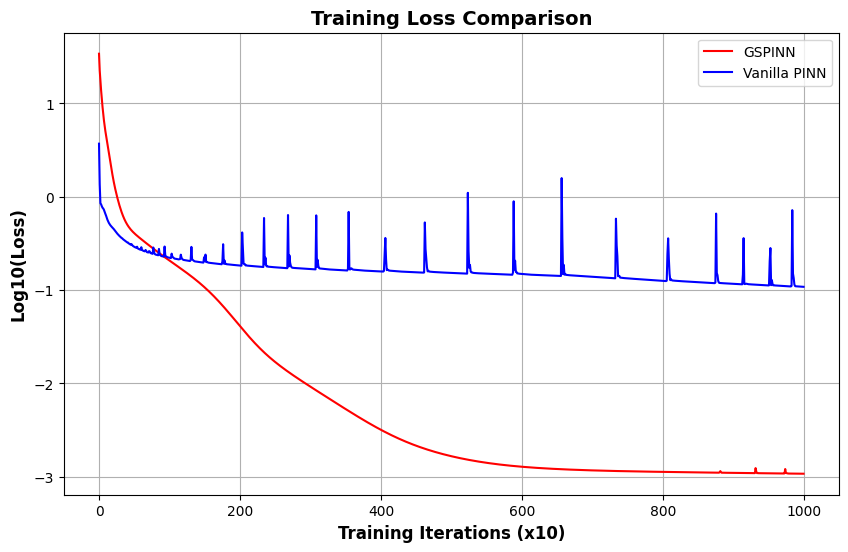

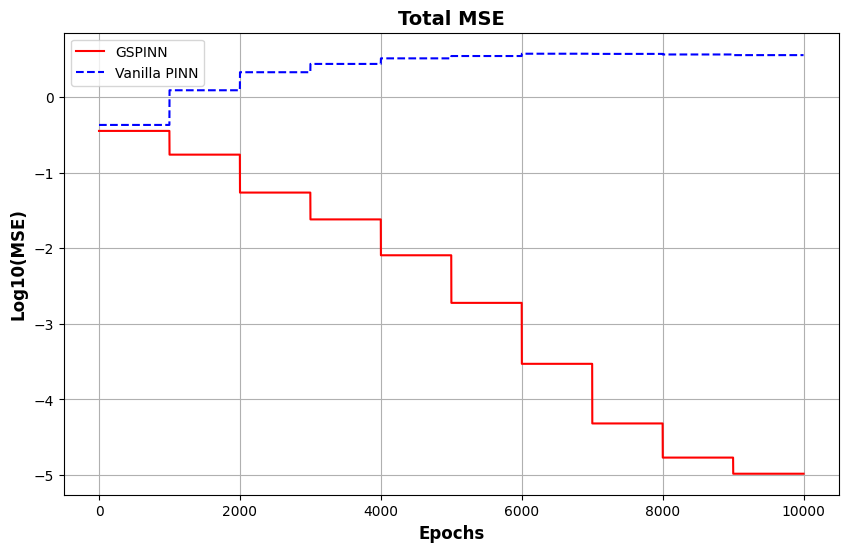

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(loss_values_multiscale[::10]), 'r-', label='GSPINN')
plt.plot(np.log10(loss_values_vanilla[::10]), 'b-', label='Vanilla PINN')
plt.xlabel('Training Iterations (x10)', fontsize=12, fontweight='bold')
plt.ylabel('Log10(Loss)', fontsize=12, fontweight='bold')
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
epochs = np.arange(0, epoch_num, 100)
plt.plot(np.log10(mse_history_multiscale['total']), 'r-', label='GSPINN')
plt.plot(np.log10(mse_history_vanilla['total']), 'b--', label='Vanilla PINN')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Log10(MSE)', fontsize=12, fontweight='bold')
plt.title('Total MSE', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_212/679888112.py:54: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_212/679888112.py:55: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
/tmp/ipykernel_212/679888112.py:56: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


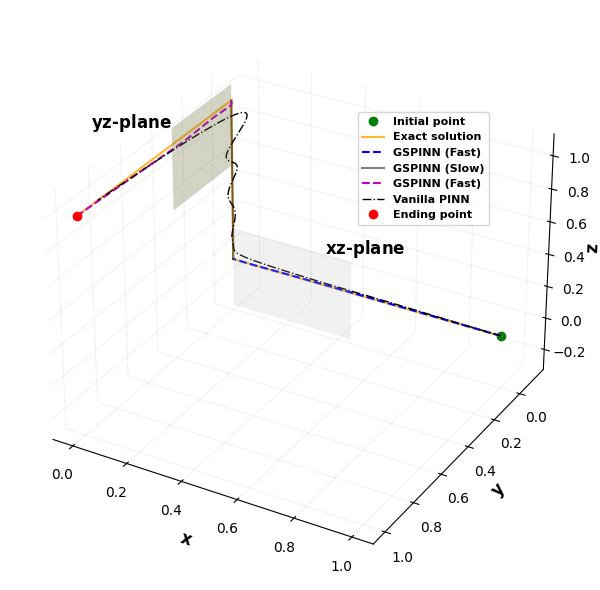

In [18]:
# 3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white') 

ax.plot(x_init, y_init, z_init, 'go', label='Initial point')

# Exact
ax.plot(x_exact_fast, y_exact_fast, z_exact_fast, '-', color='orange', label='Exact solution', alpha=0.8)
ax.plot(x_exact_slow , y_exact_slow , z_exact_slow , '-', color='orange', alpha=0.8)
ax.plot(x_exact_fast2, y_exact_fast2, z_exact_fast2, color='orange', alpha=0.8)

# Plotting the xz-plane
x_plane = np.linspace(0, 0.45, 100)
z_plane = np.linspace(-0.3, 0.2, 100)
X_plane, Z_plane = np.meshgrid(x_plane, z_plane)
Y_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.2, color='lightgrey')

# Plotting the yz-plane
y_plane = np.linspace(0, 0.4, 100)
z_plane = np.linspace(0.6, 1.1, 100)
Y_plane, Z_plane = np.meshgrid(y_plane, z_plane)
X_plane = np.zeros_like(Y_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color=(1.0, 1.0, 0.5))

# Annotation for xz-plane using LaTeX
ax.text(0.35, 0, 0.2, r"$\mathbf{xz}$-plane", color='black', fontsize=12, ha='left', fontweight='bold')

# Annotation for yz-plane using LaTeX
ax.text(0, 0.4, 1.1, r"$\mathbf{yz}$-plane", color='black', fontsize=12, ha='right', fontweight='bold')

# Multiscale PINN (GSPINN)
ax.plot(x_pred_fast, y_pred_fast, z_pred_fast, 'b--', label='GSPINN (Fast)')
ax.plot(x_pred_slow , y_pred_slow , z_pred_slow , 'k-', label='GSPINN (Slow)', alpha=0.5)
ax.plot(x_pred_fast2, y_pred_fast2, z_pred_fast2, 'm--', label='GSPINN (Fast)')

# Vanilla PINN
ax.plot(x_pred_vanilla, y_pred_vanilla, z_pred_vanilla, 'k-.', label='Vanilla PINN', linewidth=1)

ax.plot(x_end, y_end, z_end, 'ro', label='Ending point')

# Setting bold axis labels
ax.set_xlabel(r'$\mathbf{x}$', fontsize=12, fontweight='bold')
ax.set_ylabel(r'$\mathbf{y}$', fontsize=12, fontweight='bold')
ax.set_zlabel(r'$\mathbf{z}$', fontsize=12, fontweight='bold', labelpad=-1)

ax.legend(prop={'size': 8, 'weight': 'bold'}, bbox_to_anchor=(0.6, 0.83))

#ax.legend(prop={'size': 8}, bbox_to_anchor=(0.6, 0.83))
ax.invert_yaxis()

# Set the pane colors to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set the grid colors to very light gray
ax.xaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05)) 
ax.yaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))
ax.zaxis._axinfo['grid'].update(color=(0.05, 0.05, 0.05, 0.05))

plt.tight_layout()
plt.show()
